In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from xgboost import XGBClassifier

In [ ]:
def load_data(filepath='combined_dementia_dataset.csv'):
    """Loads the dataset from the given filepath."""
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded '{filepath}'.")
        return df
    except FileNotFoundError:
        print(f"Error: '{filepath}' not found.")
        
        print("Please run '1_prepare_and_combine.py' first to generate it.")
        return None

In [3]:
def preprocess_data(df):
    """Splits and scales the data for training and testing."""
    # Define features (X) and target (y)
    X = df.drop(['Dementia', 'CDR'], axis=1)
    y = df['Dementia']
    feature_names = X.columns.tolist()

    # Split the data (85% train, 15% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Data successfully split and scaled.")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names

In [4]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Trains an XGBoost model using GridSearchCV to find optimal hyperparameters
    and then evaluates its performance.
    """
    # --- NEW: Define the parameter grid for XGBoost ---
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.7, 1.0]
    }

    # --- NEW: Set up GridSearchCV with XGBClassifier ---
    print("Starting hyperparameter tuning for XGBoost with GridSearchCV...")
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    
    print("\nHyperparameter tuning complete.")
    print("Best parameters found: ", grid_search.best_params_)

    # Get the best model found by the grid search
    best_model = grid_search.best_estimator_

    # --- Evaluate the BEST model ---
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n--- Model Evaluation (with best XGBoost model) ---")
    print(f"Model Accuracy: {accuracy:.4f}\n") # Increased precision for comparison
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualize and save the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Nondemented', 'Demented'],
                yticklabels=['Nondemented', 'Demented'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Best XGBoost Model)')
    plt.savefig('confusion_matrix.png')
    print("\nConfusion matrix plot saved as 'confusion_matrix.png'")
    plt.show()
    
    return best_model


In [5]:
def save_artifacts(model, scaler, feature_names):
    """Saves the model, scaler, and feature names to disk."""
    joblib.dump(model, 'dementia_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(feature_names, 'feature_names.pkl')
    print("Model, scaler, and feature names saved successfully!")
    print("\nYou can now run '3_questionnaire.py' to make predictions.")

In [6]:
def main():
    """Main function to orchestrate the model training pipeline."""
    df = load_data()
    if df is not None:
        X_train, X_test, y_train, y_test, scaler, features = preprocess_data(df)
        model = train_and_evaluate(X_train, y_train, X_test, y_test)
        save_artifacts(model, scaler, features)


Successfully loaded 'combined_dementia_dataset.csv'.
Data successfully split and scaled.
Starting hyperparameter tuning for XGBoost with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Bhuwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperparameter tuning complete.
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}

--- Model Evaluation (with best XGBoost model) ---
Model Accuracy: 0.7759

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        31
           1       0.79      0.70      0.75        27

    accuracy                           0.78        58
   macro avg       0.78      0.77      0.77        58
weighted avg       0.78      0.78      0.77        58


Confusion matrix plot saved as 'confusion_matrix.png'


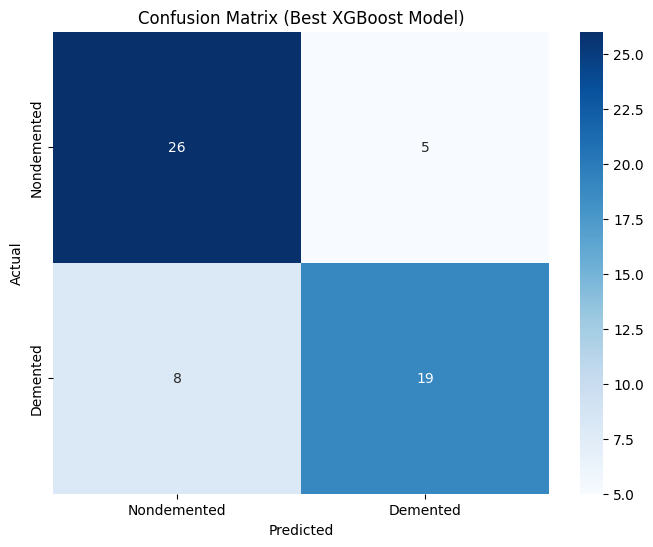

Model, scaler, and feature names saved successfully!

You can now run '3_questionnaire.py' to make predictions.


In [7]:
if __name__ == '__main__':
    main()